In [19]:
data=pd.read_csv("HAM10000_metadata.csv")

In [20]:
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [21]:
data=data.dropna()

In [22]:
data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [23]:
print(data['dx'].value_counts())

dx
nv       6660
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [24]:
balanced_df = data.groupby('dx').sample(n=115, random_state=42)

In [25]:
print(balanced_df['dx'].value_counts())

dx
akiec    115
bcc      115
bkl      115
df       115
mel      115
nv       115
vasc     115
Name: count, dtype: int64


In [26]:
balanced_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
9918,HAM_0006252,ISIC_0024646,akiec,histo,70.0,female,face
9797,HAM_0006481,ISIC_0027753,akiec,histo,70.0,male,upper extremity
9937,HAM_0007038,ISIC_0032404,akiec,histo,70.0,male,face
9696,HAM_0006898,ISIC_0029041,akiec,histo,80.0,male,scalp
9780,HAM_0002441,ISIC_0030491,akiec,histo,80.0,male,scalp


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import color, filters, morphology, measure
from skimage.util import img_as_ubyte
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


In [ ]:
def load_image(path, size=256):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    scale = size / max(h, w)
    new_w, new_h = int(w*scale), int(h*scale)
    img_resized = cv2.resize(img, (new_w, new_h))
    
    # buat canvas square
    canvas = np.zeros((size, size, 3), dtype=np.uint8)
    x_offset = (size - new_w) // 2
    y_offset = (size - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized
    
    return canvas


In [ ]:
def dullrazor(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    img_inpaint = cv2.inpaint(img_rgb, mask, 3, cv2.INPAINT_TELEA)
    return img_inpaint


In [ ]:
def denoise(img_rgb):
    return cv2.fastNlMeansDenoisingColored(img_rgb, None, 3, 3, 7, 21)
    

In [ ]:
def normalize_color(img_rgb):
   
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    img_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

In [ ]:
def segment_otsu(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    thresh = filters.threshold_otsu(gray)
    mask = (gray < thresh).astype(np.uint8)
    mask = morphology.remove_small_holes(mask.astype(bool), 200).astype(np.uint8)
    mask = morphology.remove_small_objects(mask.astype(bool), 200).astype(np.uint8)
    return mask


In [ ]:
def extract_features(img_rgb, mask):
    features = []

    gray = img_as_ubyte(color.rgb2gray(img_rgb))
    glcm = graycomatrix(gray, distances=[1,2], angles=[0,np.pi/4,np.pi/2], symmetric=True, normed=True)
    for prop in ['contrast', 'energy', 'homogeneity', 'correlation']:
        features.append(graycoprops(glcm, prop).mean())

    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    features.append(lbp.mean())

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    features += list(hsv.mean(axis=(0,1)))
    features += list(img_rgb.mean(axis=(0,1)))
    features += list(img_rgb.std(axis=(0,1)))

    if mask is not None:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            c = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            circularity = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0
            features.append(circularity)
            M = cv2.moments(c)
            eccentricity = ((M['mu20'] - M['mu02'])**2 - 4*(M['mu11']**2))/((M['mu20']+M['mu02'])**2) if (M['mu20']+M['mu02'])!=0 else 0
            features.append(float(eccentricity))
            hull = cv2.convexHull(c)
            solidity = area / cv2.contourArea(hull) if cv2.contourArea(hull)>0 else 0
            features.append(solidity)
        else:
            features += [0,0,0]

    return features

In [ ]:
def process_image(path, size=256):
    img = load_image(path, size)
    img = dullrazor(img)
    img = denoise(img)
    img = normalize_color(img)
    mask = segment_otsu(img)
    feats = extract_features(img, mask)
    return feats


In [ ]:
def main_simple():
    IMAGES_DIR = "./HAM10000_images_part_1"
    SIZE = 256

    df = balanced_df
    X, y = [], []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(IMAGES_DIR, row['image_id'] + ".jpg")
        if not os.path.exists(img_path):
            print("File not found:", img_path)
            continue
        feats = process_image(img_path, SIZE)
        X.append(feats)
        y.append(row['dx'])

    X = np.array(X)
    y = np.array(y)

    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train SVM
    model = SVC(kernel="rbf", C=3, gamma="scale")
    model.fit(X_train, y_train)

    # Predict & report
    pred = model.predict(X_test)
    print("\n=== Classification Report ===")
    print(classification_report(y_test, pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, pred))

if __name__ == "__main__":
    main_simple()


100%|██████████| 805/805 [03:19<00:00,  4.03it/s]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.41      0.57      0.47        23
           1       0.26      0.22      0.24        23
           2       0.32      0.30      0.31        23
           3       0.33      0.35      0.34        23
           4       0.50      0.43      0.47        23
           5       0.68      0.65      0.67        23
           6       0.59      0.57      0.58        23

    accuracy                           0.44       161
   macro avg       0.44      0.44      0.44       161
weighted avg       0.44      0.44      0.44       161


Confusion Matrix:
[[13  2  3  3  2  0  0]
 [ 7  5  4  5  1  0  1]
 [ 5  1  7  2  4  1  3]
 [ 3  4  1  8  1  3  3]
 [ 2  3  4  2 10  1  1]
 [ 0  1  2  2  2 15  1]
 [ 2  3  1  2  0  2 13]]


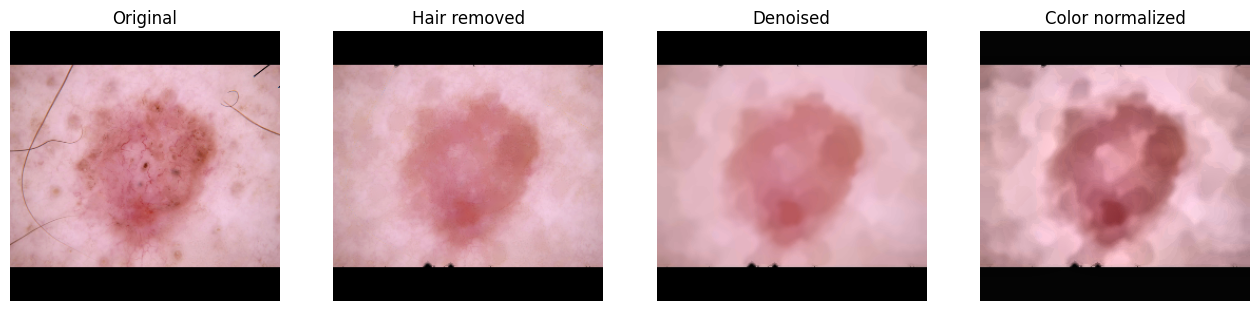

In [ ]:
img = load_image("./HAM10000_images_part_1/ISIC_0024332.jpg")
img_dr = dullrazor(img)
img_dn = denoise(img_dr)
img_cn = normalize_color(img_dn)

fig, axes = plt.subplots(1, 4, figsize=(16,4))
axes[0].imshow(img); axes[0].set_title("Original")
axes[1].imshow(img_dr); axes[1].set_title("Hair removed")
axes[2].imshow(img_dn); axes[2].set_title("Denoised")
axes[3].imshow(img_cn); axes[3].set_title("Color normalized")
for ax in axes:
    ax.axis('off')
plt.show()

In [51]:
mask = segment_kmeans(img_cn)
plt.imshow(mask, cmap='gray')
plt.title("Segmented lesion (KMeans)")
plt.axis('off')
plt.show()


NameError: name 'segment_kmeans' is not defined

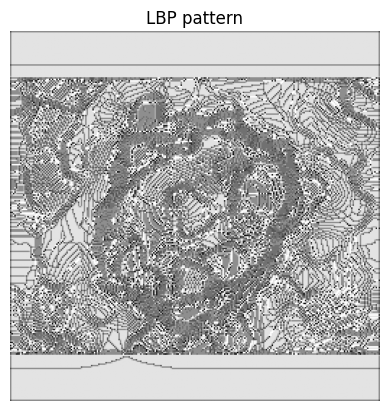

In [52]:
from skimage.feature import local_binary_pattern

gray = cv2.cvtColor(img_cn, cv2.COLOR_RGB2GRAY)
lbp = local_binary_pattern(gray, 8, 1, method='uniform')

plt.imshow(lbp, cmap='gray')
plt.title("LBP pattern")
plt.axis('off')
plt.show()


In [53]:
from skimage.feature import greycomatrix

gray_q = (gray // 32).astype(np.uint8)  # quantize
glcm = greycomatrix(gray_q, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)

plt.imshow(glcm[:, :, 0, 0], cmap='hot')
plt.title("GLCM (distance=1, angle=0)")
plt.colorbar()
plt.show()


ImportError: cannot import name 'greycomatrix' from 'skimage.feature' (c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\__init__.py)

In [54]:
import cv2

contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contour = img_cn.copy()
cv2.drawContours(img_contour, contours, -1, (255,0,0), 2)

plt.imshow(img_contour)
plt.title("Lesion contour")
plt.axis('off')
plt.show()


NameError: name 'mask' is not defined